In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
plt.style.use(["science","bright","grid"])

from nanonets import Simulation
from nanonets.utils import BLUE_COLOR, RED_COLOR
from tqdm import tqdm

# Parameter
N_NP    = 9
idx_g   = [12,3,4]
idx_b   = [15,30,20]
topo    = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
            [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],[N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]], "electrode_type": ['constant']*8}

# Voltage
U0      = 0.02
volt    = np.zeros(len(topo["e_pos"])+1)
volt[0] = U0
volt    = volt[np.newaxis]

# Disorder
N_J_TOTAL   = 2*N_NP*(N_NP-1)
MEAN_R2_MAX = np.inf #1e9

In [2]:
def run_simulation(MEAN_R2=25, cut=None, seed=0):
    
    # Setup Network
    sim_c = Simulation(topo)
    if MEAN_R2 == 25:
        sim_c = Simulation(topo)
    else:
        res_info2 = {'N':N_J_TOTAL//3,'mean_R':MEAN_R2,'std_R':0.0}
        sim_c = Simulation(topo, res_info2=res_info2, seed=seed)
        
    if cut is not None:
        sim_c.update_junction_resistances(junctions=[cut],R=MEAN_R2_MAX)

    # Run
    sim_c.run_static_voltages(volt, 7)

    y = sim_c.get_observable_storage()
    I = sim_c.get_network_current_storage()

    return y, I

In [3]:
R_vals = [25,50,100,200,400,800,1600]
y_olds = {}
y_news = {}
I_olds = {}
I_news = {}
F_vals = {}

for seed in idx_g+idx_b:

    y_olds[seed] = []
    y_news[seed] = []
    I_olds[seed] = []
    I_news[seed] = []
    F_vals[seed] = []

    for R2 in tqdm(R_vals):

        # First Run
        y_old, I_old = run_simulation(MEAN_R2=R2, cut=None, seed=seed)

        # Find most dominant junction
        keys = []
        vals = []
        for key, val in I_old.items():
            keys.append(key)
            vals.append(val[0])
        juncs = np.array(keys)[np.argsort(-np.array(vals))]-len(topo["e_pos"])
        for junc in juncs:
            if junc[0] >= 0 and junc[1] >= 0:
                junc_to_deleat = junc
                break

        # Second Run
        y_new, I_new = run_simulation(MEAN_R2=R2, cut=junc_to_deleat, seed=seed)
        

        # Append results
        y_olds[seed].append(y_old[0])
        y_news[seed].append(y_new[0])
        F_vals[seed].append(1 - y_new[0]/y_old[0])
        I_olds[seed].append(I_old)
        I_news[seed].append(I_new)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:43<00:00,  6.22s/it]


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22713/422475702.py:2: SyntaxWarning: invalid escape sequence '\m'
  label   = ['$Min~\mathcal{G}$','$Max~\mathcal{G}$']
/tmp/ipykernel_22713/422475702.py:2: SyntaxWarning: invalid escape sequence '\m'
  label   = ['$Min~\mathcal{G}$','$Max~\mathcal{G}$']
/tmp/ipykernel_22713/422475702.py:13: SyntaxWarning: invalid escape sequence '\m'
  _   = ax.set_xlabel("$R_2~[\mathrm{M\Omega}]$")


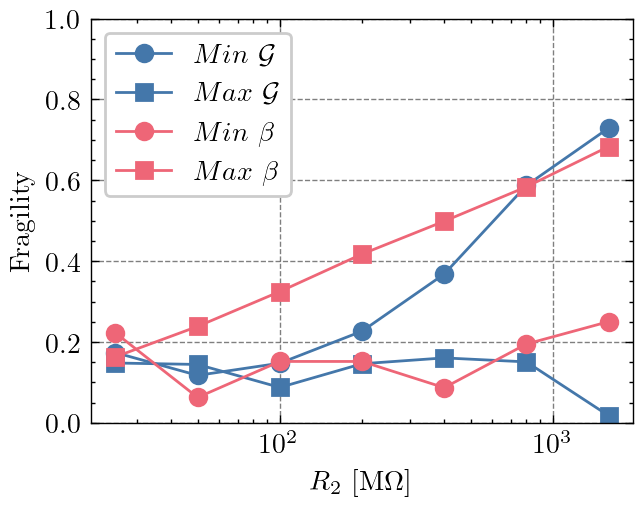

In [5]:
ms      = ['o','s','^']
label   = ['$Min~\mathcal{G}$','$Max~\mathcal{G}$'] 
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for n, i in enumerate(idx_g[::2]):
    ax.plot(R_vals, F_vals[i], color=BLUE_COLOR, marker=ms[n], label=label[n])
_   = ax.legend()

label   = ['$Min~\\beta$','$Max~\\beta$'] 
for n, i in enumerate(idx_b[::2]):
    ax.plot(R_vals, F_vals[i], c=RED_COLOR, marker=ms[n], label=label[n])
_   = ax.set_xscale('log')
_   = ax.set_xlabel("$R_2~[\mathrm{M\Omega}]$")
_   = ax.set_ylabel("Fragility")
_   = ax.set_ylim(0,1)
_   = ax.legend()

# fig.savefig("fragility.png")